<a href="https://colab.research.google.com/github/pauloacs/Deep-Learning-for-solving-the-poisson-equation/blob/main/ConvLstmModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Mount google drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!cp '/content/drive/MyDrive/openfoamDATA/all_data_vanKarman.hdf5' all_data.hdf5

In [ ]:
from keras.callbacks import EarlyStopping, TensorBoard
import tensorflow as tf
import os
import shutil
import time
import h5py
import keras
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as colors
import math
from numba import njit

# Read and prepare data

# read data with x,y

In [ ]:
def read_dataset(path=None, split=0.8, print_shape=False):
    hdf5_file = h5py.File(path, "r")
    x = hdf5_file["sim_data"][:20, 0:20, ...]
    y = hdf5_file["sim_data"][:20, 1:21, ...]
    sim_no = hdf5_file["sim_no"][:, 0]
    hdf5_file.close()


    @njit
    def index(array, item):
      for idx, val in np.ndenumerate(array):
        if val == item:
            return idx
    # If no item was found return None, other return types might be a problem due to
    # numbas type inference.


    for i in range(y.shape[0]):
      indice = index(y[i,0,:,0] , -100.0 )[0]
      if np.max(y[i,:,:indice,0])-np.min(y[i,:,:indice,0]) != 0:
        y[i,:,:indice,0] = (y[i,:,:indice,0] - np.ones((y[i,:,:indice,0].shape))*np.min(y[i,:,:indice,0]))/(np.max(y[i,:,:indice,0])-np.min(y[i,:,:indice,0]))
        y[i,:,:indice,1] = (y[i,:,:indice,1] - np.ones((y[i,:,:indice,1].shape))*np.min(y[i,:,:indice,1]))/(np.max(y[i,:,:indice,1])-np.min(y[i,:,:indice,1]))
        y[i,:,:indice,2] = (y[i,:,:indice,2] - np.ones((y[i,:,:indice,2].shape))*np.min(y[i,:,:indice,2]))/(np.max(y[i,:,:indice,2])-np.min(y[i,:,:indice,2]))

    for i in range(x.shape[0]):
      indice = index(x[i,0,:,0] , -100.0 )[0]
      if np.max(x[i,:,:indice,0])-np.min(x[i,:,:indice,0]) != 0:
        x[i,:,:indice,0] = (x[i,:,:indice,0] - np.ones((x[i,:,:indice,0].shape))*np.min(x[i,:,:indice,0]))/(np.max(x[i,:,:indice,0])-np.min(x[i,:,:indice,0]))
        x[i,:,:indice,1] = (x[i,:,:indice,1] - np.ones((x[i,:,:indice,1].shape))*np.min(x[i,:,:indice,1]))/(np.max(x[i,:,:indice,1])-np.min(x[i,:,:indice,1]))
        x[i,:,:indice,2] = (x[i,:,:indice,2] - np.ones((x[i,:,:indice,2].shape))*np.min(x[i,:,:indice,2]))/(np.max(x[i,:,:indice,2])-np.min(x[i,:,:indice,2]))

    total_sim = x.shape[0]
    x_train = x[:int(total_sim * split), ...]
    y_train = y[:int(total_sim * split), ...]
    x_test = x[int(total_sim * split):total_sim, ...]
    y_test = y[int(total_sim * split):total_sim, ...]
    sim_no_train = sim_no[:int(total_sim * split), ...]
    sim_no_test = sim_no[int(total_sim * split):total_sim, ...]

    if print_shape:
        print("total_sim: {}\nx_train.shape: {}\ny_train.shape: {}\nx_test.shape: {}\ny_test.shape: {}\n".format(
            total_sim,
            x_train.shape,
            y_train.shape,
            x_test.shape,
            y_test.shape))

    return x_train, y_train, x_test, y_test

In [ ]:
hdf5_path = '/content/all_data.hdf5'
x_train, y_train, x_test, y_test = read_dataset(hdf5_path, split=0.8, print_shape=True)

assert not np.any(np.isnan(x_train))
assert not np.any(np.isnan(y_train))

assert not np.any(np.isnan(x_test))
assert not np.any(np.isnan(y_test))

total_sim: 20
x_train.shape: (16, 20, 13104, 5)
y_train.shape: (16, 20, 13104, 5)
x_test.shape: (4, 20, 13104, 5)
y_test.shape: (4, 20, 13104, 5)



In [ ]:
train_len = x_train.shape[0]

# Loss function

x_train : (n,50,150,5)

last collumn: 0-ux 1-uy 2-p 3-x 4-y

In [ ]:
from numpy import random
@tf.function
def f_model(train):
  
  dtype = "float32"

  #num = 32

  #idxs=random.randint(train.shape[0], size=(num)) 
  #idxs = np.array(idxs)
  
  #train = train[idxs,:,:]
  #ux = train[:,:,0]
  #uy = train[:,:,1]
  #p = train[:,:,2]
  x = tf.convert_to_tensor(train[:,:,0], dtype=dtype)
  y = tf.convert_to_tensor(train[:,:,1], dtype=dtype)
  t = tf.convert_to_tensor(train[:,:,2], dtype=dtype)

  with tf.GradientTape(persistent=True) as tape:
    tape.watch(x)
    tape.watch(y)
    tape.watch(t)
    #X_f = tf.stack([ux , uy , p , x, y , t], axis=2)
    X_f = tf.stack([x, y , t], axis=2)

    y_pred = model(X_f)

    ux = y_pred[:,:,0]
    uy = y_pred[:,:,1]
    p = y_pred[:,:,2]

    ux_x = tape.gradient(ux,x)
    ux_y = tape.gradient(ux,y)

    uy_x = tape.gradient(uy, x)
    uy_y = tape.gradient(uy,y)

  ux_t = tape.gradient(ux,t)
  uy_t = tape.gradient(uy,t)

  ux_xx = tape.gradient(ux_x,x)
  ux_yy = tape.gradient(ux_y,y)

  uy_xx = tape.gradient(uy_x,x)
  uy_yy = tape.gradient(uy_y,y)

  p_x = tape.gradient(p,x)
  p_y = tape.gradient(p,y)

  res = ux_x + uy_y

  nu= 1.51e-4
  residual_NS_x = ux_t + ux * ux_x + uy * ux_y + p_x - nu * (ux_xx + ux_yy)
  residual_NS_y = uy_t + ux * uy_x + uy * uy_y + p_y - nu * (uy_xx + uy_yy)

  cont_residual = tf.square(res)
  NSx_residual = tf.square(residual_NS_x)
  NSy_residual = tf.square(residual_NS_y)

  return cont_residual, NSx_residual, NSy_residual

In [ ]:
def eq_loss():
  def equation_loss(y_true, y_pred, x):

    res, residual_NS_x, residual_NS_y = f_model(x)

    ux = y_true[:,:,0]
    uy = y_true[:,:,1]
    p = y_true[:,:,2]

    ux_pred = y_pred[:,:,0]
    uy_pred = y_pred[:,:,1]
    p_pred = y_pred[:,:,2]
    
    return   (tf.square(tf.square(ux - ux_pred)) + \
                  tf.square(tf.square(uy - uy_pred)) + \
                  tf.square(tf.square(p - p_pred))) * 1 + \
                  (res + residual_NS_x + residual_NS_y)
  return equation_loss

# Dense model - flat

In [ ]:
#rearrange data
x_train = x_train.reshape(x_train.shape[0]*50*250,3)
y_train = y_train.reshape(y_train.shape[0]*50*250,3)
x_test = x_test.reshape(x_test.shape[0]*50*250,3)
y_test = y_test.reshape(y_test.shape[0]*50*250,3)

ValueError: ignored

In [ ]:
def dense_model():
  input_layer = tf.keras.Input (3)
  #x = tf.keras.layers.Masking(mask_value=0.)(input_layer)
  x = tf.keras.layers.Dense(10, activation='relu')(input_layer)
  x = tf.keras.layers.Dense(10, activation='relu')(x)
  x = tf.keras.layers.Dense(10, activation='relu')(x)
  x = tf.keras.layers.Dense(10, activation='relu')(x)
  output_layer = tf.keras.layers.Dense(3)(x)
  
  model = tf.keras.Model(inputs=[input_layer], outputs = [output_layer])

  print(model.summary())
  return model

In [ ]:
def f_model(train):
  
  dtype = "float32"

  x = tf.convert_to_tensor(train[:,0], dtype=dtype)
  y = tf.convert_to_tensor(train[:,1], dtype=dtype)
  t = tf.convert_to_tensor(train[:,2], dtype=dtype)

  with tf.GradientTape(persistent=True) as tape:
    tape.watch(x)
    tape.watch(y)
    tape.watch(t)
    X_f = tf.stack([x, y , t], axis=1)

    y_pred = model(X_f)

    ux = y_pred[:,0]
    uy = y_pred[:,1]
    p = y_pred[:,2]

    ux_x = tape.gradient(ux,x)
    ux_y = tape.gradient(ux,y)

    uy_x = tape.gradient(uy, x)
    uy_y = tape.gradient(uy,y)

  #ux_t = tape.gradient(ux,t)
  #uy_t = tape.gradient(uy,t)

  #ux_xx = tape.gradient(ux_x,x)
  #ux_yy = tape.gradient(ux_y,y)

  #uy_xx = tape.gradient(uy_x,x)
  #uy_yy = tape.gradient(uy_y,y)

  #p_x = tape.gradient(p,x)
  #p_y = tape.gradient(p,y)

  res = ux_x + uy_y

  nu= 1.51e-4
  #residual_NS_x = ux_t + ux * ux_x + uy * ux_y + p_x - nu * (ux_xx + ux_yy)
  #residual_NS_y = uy_t + ux * uy_x + uy * uy_y + p_y - nu * (uy_xx + uy_yy)

  cont_residual = tf.reduce_mean(tf.square(res))
  NSx_residual = 0.#f.reduce_mean(tf.square(residual_NS_x))
  NSy_residual = 0.#tf.reduce_mean(tf.square(residual_NS_y))

  return res, residual_NS_x, residual_NS_y

In [ ]:
def eq_loss(c):
  def equation_loss(y_true, y_pred):

    res, residual_NS_x, residual_NS_y = f_model(x_train)

    ux = y_true[:,0]
    uy = y_true[:,1]
    p = y_true[:,2]

    ux_pred = y_pred[:,0]
    uy_pred = y_pred[:,1]
    p_pred = y_pred[:,2]
    
    return   tf.reduce_sum(tf.square(ux - ux_pred)) + \
                  tf.reduce_sum(tf.square(uy - uy_pred)) + \
                  tf.reduce_sum(tf.square(p - p_pred)) + \
                  c* (tf.reduce_sum(tf.square(res)) + \
                  tf.reduce_sum(tf.square(residual_NS_x)) + \
                  tf.reduce_sum(tf.square(residual_NS_y)))
  return equation_loss

In [ ]:
lr = 1e-02
model = dense_model()
optimizer = Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.45*lr, amsgrad=True)
model.compile(loss=eq_loss(c=1), optimizer=optimizer, metrics=['MSE'])


callbacks = [EarlyStopping(monitor='val_MSE', min_delta=0.001, patience=5)]#, PlotLearning()]
train_info = model.fit(x=x_train, y=y_train, batch_size=18000, epochs=100, verbose=1, validation_data=(x_test, y_test), callbacks=callbacks)
score = model.evaluate(x=x_test, y=y_test, verbose=2)
print('Average Mean Squared Error:', score[0])
model.save('my_model.h5')

# Dense model

In [ ]:


@njit
def index(array, item):
    for idx, val in np.ndenumerate(array):
        if val == item:
            return idx
    # If no item was found return None, other return types might be a problem due to
    # numbas type inference.

def my_mse_loss():
  def equation_loss(y_true, y_pred):

    loss = 0

    for i in range(y_true.shape[0]):
      y = np.array(y_true[i,0,:,0])
      indice = index(y , -100.0 )[0]

      ux = y_true[i,:,:indice,0]
      uy = y_true[i,:,:indice,1]
      p = y_true[i,:,:indice,2]

      
      ux_pred = y_pred[i,:,:indice,0]
      uy_pred = y_pred[i,:,:indice,1]
      p_pred = y_pred[i,:,:indice,2]
      
      loss += tf.reduce_mean(tf.square(ux - ux_pred) + \
                  tf.square(uy - uy_pred) + \
                  tf.square(p - p_pred))
    loss /= y_true.shape[0]
    print(loss)
    return loss

  return equation_loss

In [ ]:
def conv_model():

  inputs = tf.keras.Input(shape=(None, 52 * 252, 3))

  layer = tf.keras.layers.Conv1D(32, 2, activation='relu', padding='same')(inputs)

  c1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(32, 2, activation='relu', padding='same'))(layer)  # (None, 50, 150, 32)
  x = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling1D(2, padding='same'))(c1)  # (None, 25, 75, 32)

  c2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(64, 2, activation='relu', padding='same'))(x)  # (None, 25, 75, 64)
  x = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling1D(2, padding='same'))(c2)  # (None, 13, 38, 64)

  c3 = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(128, 2, activation='relu', padding='same'))(x)  # (None, 13, 38, 128)
  x = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling1D(2, padding='same'))(c3)  # (None, 7, 19, 128)

  x = tf.keras.layers.ConvLSTM1D(filters=256, kernel_size=3, activation='relu',
                  recurrent_activation='hard_sigmoid', padding='same', return_sequences=True)(x)

  x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1DTranspose(128, 2, strides=2, padding='same'))(x)
  #x = tf.keras.layers.TimeDistributed(tf.keras.layers.Cropping1D(cropping=(1, 0))(x)
  x = tf.keras.layers.Add()([x, c3])

  x = tf.keras.layers.ConvLSTM1D(filters=128, kernel_size=3, activation='relu',
                  recurrent_activation='hard_sigmoid', padding='same', return_sequences=True)(x)

  x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1DTranspose(64, 2, strides=2, padding='same'))(x)
  #x = tf.keras.layers.TimeDistributed(tf.keras.layers.Cropping1D(cropping=((1, 0)))(x)
  x = tf.keras.layers.Add()([x, c2])

  x = tf.keras.layers.ConvLSTM1D(filters=64, kernel_size=3, activation='relu',
                  recurrent_activation='hard_sigmoid', padding='same', return_sequences=True)(x)

  x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1DTranspose(32, 3 , strides=2 , padding='same'))(x)
  x = tf.keras.layers.Add()([x, c1])

  x = tf.keras.layers.Conv1D(filters=3, kernel_size= 3 , activation='linear', padding='same', data_format='channels_last')(x)



  output_layer =  tf.keras.layers.Dense(3, activation='sigmoid')(x)

  model = tf.keras.Model(inputs=[inputs], outputs = [output_layer])

  print(model.summary())
  return model




In [ ]:
model=conv_model()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 13104, 0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, None, 13104,  224         input_1[0][0]                    
__________________________________________________________________________________________________
time_distributed (TimeDistribut (None, None, 13104,  2080        conv1d[0][0]                     
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, None, 6552, 3 0           time_distributed[0][0]           
______________________________________________________________________________________________

# Prepare data with TFRecord

In [ ]:
# Convert values to compatible tf.Example types.
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy()  # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))
def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))
def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))
    
def parse_single_image(image, label):
  
  #define the dictionary -- the structure -- of our single example
  data = {
        'height' : _int64_feature(image.shape[0]),
        'depth_x' : _int64_feature(image.shape[1]),
        'depth_y' : _int64_feature(label.shape[1]),
        'raw_image' : _bytes_feature(tf.io.serialize_tensor(image)),
        'label' : _bytes_feature(tf.io.serialize_tensor(label)),
    }
  #create an Example, wrapping the single features
  out = tf.train.Example(features=tf.train.Features(feature=data))

  return out

def write_images_to_tfr_short(images, labels, filename:str="images"):
  filename= filename+".tfrecords"
  writer = tf.io.TFRecordWriter(filename) #create a writer that'll store our data to disk
  count = 0

  for index in range(len(images)):

    #get the data we want to write
    current_image = images[index].astype('float64')
    current_label = labels[index].astype('float64')

    out = parse_single_image(image=current_image, label=current_label)
    writer.write(out.SerializeToString())
    count += 1

  writer.close()
  print(f"Wrote {count} elements to TFRecord")
  return count

count = write_images_to_tfr_short(x_train[:,:,:,0:3], y_train[:,:,:,0:3], filename="small_images_train")
count = write_images_to_tfr_short(x_test[:,:,:,0:3], y_test[:,:,:,0:3], filename="small_images_test")

TypeError: ignored

In [ ]:
def parse_tfr_element(element):
  #use the same structure as above; it's kinda an outline of the structure we now want to create
  data = {
      'height': tf.io.FixedLenFeature([], tf.int64),
      'label' : tf.io.FixedLenFeature([], tf.string),
      'raw_image' : tf.io.FixedLenFeature([], tf.string),
      'depth_x':tf.io.FixedLenFeature([], tf.int64),
      'depth_y':tf.io.FixedLenFeature([], tf.int64)
    }

  content = tf.io.parse_single_example(element, data)
  
  height = content['height']
  depth_x = content['depth_x']
  depth_y = content['depth_y']
  label = content['label']
  raw_image = content['raw_image']
  
  
  #get our 'feature'-- our image -- and reshape it appropriately
  
  feature = tf.io.parse_tensor(raw_image, out_type=tf.float64)
  label = tf.io.parse_tensor(label, out_type=tf.float64)


  return (feature, label)

def load_dataset(filename, batch_size, buffer_size):
  #create the dataset
  dataset = tf.data.TFRecordDataset(filename)

    #pass every single feature through our mapping function
  dataset = dataset.map(
      parse_tfr_element
  )

  #dataset = dataset.shuffle(buffer_size=buffer_size )
  #epoch = tf.data.Dataset.range(epoch_num)
  dataset = dataset.batch(batch_size)

  return dataset  
  #return tf.compat.v1.data.make_one_shot_iterator(dataset)

train_path = "/content/small_images_train.tfrecords"
test_path = "/content/small_images_test.tfrecords"

batch_size = 1

train_dataset = load_dataset(filename = train_path, batch_size= batch_size, buffer_size=1024)
test_dataset = load_dataset(filename = test_path, batch_size= batch_size, buffer_size=1024)

#train_len = x_train.shape[0]
x_train, x_test, y_train,  y_test = None, None, None, None


# prepare data for generator

In [ ]:
# Defining generator functions for train/test samples
TRAIN_LEN = x_train.shape[0]
def gen_pairs_train():
    for i in range(TRAIN_LEN):
        # Get a random image each time
        idx = np.random.randint(0,TRAIN_LEN)
        yield (x_train[idx], y_train[idx])


TEST_LEN = x_test.shape[0]
def gen_pairs_test():
    for i in range(TEST_LEN):
        # Get a random image each time
        idx = np.random.randint(0,TEST_LEN)
        yield (x_test[idx], y_test[idx])

# Function to test input pipeline
sample_x, sample_y = next(gen_pairs_train())
sample_x.shape

(13104, 6)

In [ ]:
batch_size = 32
lr = 1e-3

# Prepare the training dataset.
train_dataset = tf.data.Dataset.from_generator(generator=gen_pairs_train, output_types=(tf.float64, tf.uint8))
train_dataset = train_dataset.batch(batch_size)

# Prepare the validation dataset.
test_dataset = tf.data.Dataset.from_generator(generator=gen_pairs_test, output_types=(tf.float64, tf.uint8))
test_dataset = test_dataset.batch(batch_size)

x_train_shape0 = x_train.shape[0]
#x_train = None
#y_train = None

#x_test = None
#y_test = None

# raw data

In [ ]:
batch_size = 1


train_data = tf.data.Dataset.from_tensor_slices((x_train[:,:,:,0:3],y_train[:,:,:,0:3]))
test_data = tf.data.Dataset.from_tensor_slices((x_test[:,:,:,0:3],y_test[:,:,:,0:3]))

#train_dataset = train_data.shuffle(buffer_size=1024).batch(batch_size=batch_size)
train_dataset = train_data.batch(batch_size=batch_size)
test_dataset = test_data.batch(batch_size=batch_size)

train_len = x_train.shape[0]
x_train, x_test, y_train,  y_test = None, None, None, None




# costum training

In [ ]:
lr = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.45*lr, amsgrad=True)
#loss_object = my_mse_loss() #tf.keras.losses.MeanSquaredError()
loss_object = my_mse_loss()
#loss_object = eq_loss()
#train_acc_metric = my_mse_loss()
#val_acc_metric =my_mse_loss()

#train_acc_metric = tf.keras.metrics.MeanSquaredError()
#val_acc_metric = tf.keras.metrics.MeanSquaredError()



In [ ]:
#coding the training
#@tf.function
def apply_gradient(optimizer, model , x, y):
  with tf.GradientTape() as tape:
    logits = model(x)  #predictions from the model at this moment
    #loss_value = loss_object(y_true = y , y_pred = logits, x=x) #calculate loss given the predictions - logits
    loss_value = loss_object(y_true = y , y_pred = logits)
  gradients = tape.gradient(loss_value, model.trainable_weights)
  optimizer.apply_gradients(zip(gradients,model.trainable_weights)) #zip to build tuple

  return logits, loss_value

#@tf.function
def train_data_for_one_epoch():
  losses = []  #loss per batch
  
  #pbar=tqdm(total=len(list(enumerate(train))), position=0, leave = True, bar_format = '{1_bar}{bar}| {n_fms}/{total_fms} ')

  for step, (x_batch_train, y_batch_train) in enumerate (train_dataset):

    x_batch_train = tf.cast(x_batch_train, dtype='float32')
    y_batch_train = tf.cast(y_batch_train, dtype='float32')
    
    logits , loss_value = apply_gradient(optimizer , model , x_batch_train , y_batch_train)

    losses.append(loss_value)

    #train_acc_metric(y_batch_train, logits)
    #pbar.set_description("Training los for step %.4f" % (int(step),float(loss_value)))
    #pbar.update()
    progbar.update(step+1)

  return losses

#@tf.function
def perform_validation():
  losses = []

  for x_val, y_val in test_dataset:
    x_val = tf.cast(x_val, dtype='float32')
    y_val = tf.cast(y_val, dtype='float32')

    val_logits = model(x_val)
    #val_loss = loss_object(y_true= y_val , y_pred = val_logits, x=x_val)
    val_loss = loss_object(y_true= y_val , y_pred = val_logits)
    losses.append(val_loss)
    #val_acc_metric(y_val,val_logits)
  return losses


In [ ]:
from tqdm import tqdm 
import math

loss_object = my_mse_loss() #tf.keras.losses.MeanSquaredError()
model = conv_model()
epochs = 1
epochs_val_losses, epochs_train_losses = [], []

#train_len = 800

for epoch in range(epochs):
  
  progbar = tf.keras.utils.Progbar(math.ceil(train_len/batch_size))

  print('Start of epoch %d' %(epoch,))

  losses_train = train_data_for_one_epoch()

  losses_val  = perform_validation()
  #val_acc = val_acc_metric()
  #val_acc = losses_val

  losses_train_mean = np.mean(losses_train)
  losses_val_mean = np.mean(losses_val)
  epochs_val_losses.append(losses_val_mean)
  epochs_train_losses .append(losses_train_mean)

  print('Epoch %s: Train loss: %.4f , Validation Loss: %.4f , Train Accuracy: %.4f , Validation Accuracy: %.4f \n' % (epoch,float(losses_train_mean), float(losses_val_mean), float(losses_train_mean),  float(losses_val_mean)))
  #train_acc_metric.reset_states()
  #val_acc_metric.reset_states()


ResourceExhaustedError: ignored

In [ ]:
model.compile(optimizer,loss_object)
score = model.evaluate(test_dataset, verbose=1)

print('Average Mean Squared Error:', score)
model.save('my_model.h5')

7/7 [==============================] - 9s 1s/step - loss: 61.7711
Average Mean Squared Error: 61.771121978759766


In [ ]:
model =  tf.keras.models.load_model('my_model.h5')

# train

In [ ]:
#to search for the best lr
lr = 1e-4
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 20))
optimizer = Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.45*lr, amsgrad=True)

model = conv_model()
#loss = equation_loss()
#model.add_loss(loss)

model.compile(loss=eq_loss(c=1), optimizer=optimizer, metrics=['MSE'])



history = model.fit(x=x_train, y=y_train, epochs=100, callbacks=[lr_schedule], verbose=1)
                    
lrs = 1e-3 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-3, 1e2, 0, 8])

In [ ]:
lrs = 1e-6 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-6, 1e-1, 0, 1e6])


In [ ]:
lr = 5e-3
model = conv_model()
optimizer = Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.45*lr, amsgrad=True)
#model.compile(loss='mse', optimizer=optimizer, metrics=['MSE'])#
model.compile(loss=eq_loss(c=10), optimizer=optimizer, metrics=['MSE'])


#callbacks = [EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5)]#, PlotLearning()]
train_info = model.fit(x=x_train, y=y_train, batch_size=32, epochs=50, verbose=1, validation_data=(x_test, y_test))#, callbacks=callbacks)
score = model.evaluate(x=x_test, y=y_test, verbose=2)
print('Average Mean Squared Error:', score[0])
model.save('my_model.h5')

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 12500, 6)]        0         
_________________________________________________________________
masking_1 (Masking)          (None, 12500, 6)          0         
_________________________________________________________________
dense_9 (Dense)              (None, 12500, 20)         140       
_________________________________________________________________
dense_10 (Dense)             (None, 12500, 20)         420       
_________________________________________________________________
dense_11 (Dense)             (None, 12500, 20)         420       
_________________________________________________________________
dense_12 (Dense)             (None, 12500, 20)         420       
_________________________________________________________________
dense_13 (Dense)             (None, 12500, 20)         420 

InvalidArgumentError: ignored

# optimize with l-bfgs

In [ ]:
def loss1(y_pred, y_true):

  res, residual_NS_x, residual_NS_y = f_model(x_train)

  ux = y_true[:,:,0]
  uy = y_true[:,:,1]
  p = y_true[:,:,2]

  ux_pred = y_pred[:,:,0]
  uy_pred = y_pred[:,:,1]
  p_pred = y_pred[:,:,2]
 
  loss=   tf.reduce_mean(tf.square(ux - ux_pred)) + \
                tf.reduce_mean(tf.square(uy - uy_pred)) + \
                tf.reduce_mean(tf.square(p - p_pred)) + \
                tf.reduce_mean(tf.square(res)) + \
                tf.reduce_mean(tf.square(residual_NS_x)) + \
                tf.reduce_mean(tf.square(residual_NS_y))

  return   loss

In [ ]:
import numpy
import tensorflow as tf
import tensorflow_probability as tfp
from matplotlib import pyplot

def function_factory(model, loss, train_x, train_y):
    """A factory to create a function required by tfp.optimizer.lbfgs_minimize.
    Args:
        model [in]: an instance of `tf.keras.Model` or its subclasses.
        loss [in]: a function with signature loss_value = loss(pred_y, true_y).
        train_x [in]: the input part of training data.
        train_y [in]: the output part of training data.
    Returns:
        A function that has a signature of:
            loss_value, gradients = f(model_parameters).
    """

    # obtain the shapes of all trainable parameters in the model
    shapes = tf.shape_n(model.trainable_variables)
    n_tensors = len(shapes)

    # we'll use tf.dynamic_stitch and tf.dynamic_partition later, so we need to
    # prepare required information first
    count = 0
    idx = [] # stitch indices
    part = [] # partition indices

    for i, shape in enumerate(shapes):
        n = numpy.product(shape)
        idx.append(tf.reshape(tf.range(count, count+n, dtype=tf.int32), shape))
        part.extend([i]*n)
        count += n

    part = tf.constant(part)

    @tf.function
    def assign_new_model_parameters(params_1d):
        """A function updating the model's parameters with a 1D tf.Tensor.
        Args:
            params_1d [in]: a 1D tf.Tensor representing the model's trainable parameters.
        """

        params = tf.dynamic_partition(params_1d, part, n_tensors)
        for i, (shape, param) in enumerate(zip(shapes, params)):
            model.trainable_variables[i].assign(tf.reshape(param, shape))

    # now create a function that will be returned by this factory
    @tf.function
    def f(params_1d):
        """A function that can be used by tfp.optimizer.lbfgs_minimize.
        This function is created by function_factory.
        Args:
           params_1d [in]: a 1D tf.Tensor.
        Returns:
            A scalar loss and the gradients w.r.t. the `params_1d`.
        """

        # use GradientTape so that we can calculate the gradient of loss w.r.t. parameters
        with tf.GradientTape() as tape:
            # update the parameters in the model
            assign_new_model_parameters(params_1d)
            # calculate the loss
            loss_value = loss(train_y, model(train_x))
        # calculate gradients and convert to 1D tf.Tensor
        grads = tape.gradient(loss_value, model.trainable_variables)
        grads = tf.dynamic_stitch(idx, grads)

        #grad_flat = []
        #for g in grads:
        #    grad_flat.append(tf.reshape(g, [-1]))
        #grad_flat = tf.concat(grad_flat, 0)

        # print out iteration & loss
        f.iter.assign_add(1)
        tf.print("Iter:", f.iter, "loss:", loss_value)

        # store loss value so we can retrieve later
        tf.py_function(f.history.append, inp=[loss_value], Tout=[])

        return loss_value, grads

    # store these information as members so we can use them outside the scope
    f.iter = tf.Variable(0)
    f.idx = idx
    f.part = part
    f.shapes = shapes
    f.assign_new_model_parameters = assign_new_model_parameters
    f.history = []

    return f

def plot_helper(inputs, outputs, title, fname):
    """Plot helper"""
    pyplot.figure()
    pyplot.tricontourf(inputs[:, 0], inputs[:, 1], outputs.flatten(), 100)
    pyplot.xlabel("x")
    pyplot.ylabel("y")
    pyplot.title(title)
    pyplot.colorbar()
    pyplot.savefig(fname)


In [ ]:

#model = load_model('my_model.h5')
# use float64 by default
tf.keras.backend.set_floatx("float32")


loss = eq_loss(c=1)
func = function_factory(model, loss, x_train, y_train)

# convert initial model parameters to a 1D tf.Tensor
init_params = tf.dynamic_stitch(func.idx, model.trainable_variables)

# train the model with L-BFGS solver
results = tfp.optimizer.lbfgs_minimize(value_and_gradients_function=func, initial_position=init_params, max_iterations=500)

# after training, the final optimized parameters are still in results.position
# so we have to manually put them back to the model
func.assign_new_model_parameters(results.position)

# print out history
print("\n"+"="*80)
print("History")
print("="*80)
print(*func.history, sep='\n')

In [ ]:
score = model.evaluate(x=x_test, y=y_test, verbose=2)
print('Average Mean Squared Error:', score[0])

5/5 - 2s - loss: 0.5742 - MSE: 0.1862
Average Mean Squared Error: 0.5741959810256958


# To plot

In [ ]:
hdf5_path = '/content/all_data.hdf5'
x_train, y_train, x_test, y_test = read_dataset(hdf5_path, split=0.8, print_shape=True)

250
50
total_sim: 5.0
x_train.shape: (200, 13104, 6)
y_train.shape: (200, 13104, 3)
x_test.shape: (50, 13104, 6)
y_test.shape: (50, 13104, 3)



In [ ]:
model =  tf.keras.models.load_model('my_model.h5')

In [ ]:
i=10
sim= 3
variable = 0
x = x_train[sim,(i)*52*252:(i+1)*52*252,0]
y = x_train[sim,(i)*52*252:(i+1)*52*252,1]
z_partida = x_train[sim,(i)*52*252:(i+1)*52*252,variable]
z = y_train[sim,(i)*52*252:(i+1)*52*252,variable]
z_model = model(x_train[sim,:,:].reshape((1,) + (13104,3)))[0,(i)*52*252:(i+1)*52*252,variable]

print(z_model.shape)
print(z.shape)


fig = plt.figure(figsize=(20,20))

plt.subplot(412)
plt.ylabel('PINN', fontsize=15)
plt.scatter(x, y, c=z_model, cmap='jet', vmax = 2, vmin=0)
plt.colorbar()

plt.subplot(411)
plt.ylabel('PINN-partida', fontsize=15)
plt.scatter(x, y, c=z_partida, cmap='jet', vmax = 2, vmin=0)
plt.colorbar()


plt.subplot(413)
plt.ylabel('OpenFOAM', fontsize=15)
plt.scatter(x, y, c=z, cmap='jet', vmax = 2, vmin=0)
plt.colorbar()

plt.show()

ValueError: ignored

x,y,t - inputs

In [ ]:
@njit
def index(array, item):
    for idx, val in np.ndenumerate(array):
        if val == item:
            return idx
    # If no item was found return None, other return types might be a problem due to
    # numbas type inference.



sim= 0
variable = 1
indice = index(np.array(y_test[sim*50 +1 ,:,0]) , -100.0 )[0]
path='/content/plots/'

try:
    shutil.rmtree(path)
except OSError as e:
    print ("")

os.makedirs(path)



for i in range(5):

  x = x_test[i,:indice,3]
  y = x_test[i,:indice,4]
  z_model = model(x_test[i,:,0:3].reshape((1,) + (13104,3)))[:,:indice,:]
  print(z_model.shape)
  fig = plt.figure(figsize=(20,20))

  plt.subplot(412)
  plt.ylabel('p - Prediction (t)', fontsize=15)
  plt.scatter(x, y, c=z_model[0,:,2], cmap='jet', vmax = 1, vmin=0)
  plt.colorbar()

  z_partida = x_test[i,:indice,2]
  z = y_test[i,:indice,2]

  plt.subplot(413)
  plt.ylabel('p - CFD (t)', fontsize=15)
  plt.scatter(x, y, c=z, cmap='jet', vmax = 1, vmin=0)
  plt.colorbar()

  plt.subplot(411)
  plt.ylabel('p - CFD (t-1)', fontsize=15)
  plt.scatter(x, y, c=z_partida, cmap='jet', vmax = 1, vmin=0)
  plt.colorbar()

  #plt.show()
  plt.subplots_adjust(left=0.2, wspace=0.8, top=0.85)
  plt.savefig('/content/plots/p' + str(i) + '.png')
  plt.close()

  fig = plt.figure(figsize=(20,20))
  plt.subplot(412)
  plt.ylabel('ux - Prediction (t)', fontsize=15)
  plt.scatter(x, y, c=z_model[0,:,0], cmap='jet', vmax = 1, vmin=0)
  plt.colorbar()

  z_partida = x_test[i,:indice,0]
  z = y_test[i,:indice,0]


  plt.subplot(413)
  plt.ylabel('ux -CFD (t)', fontsize=15)
  plt.scatter(x, y, c=z, cmap='jet', vmax = 1, vmin=0)
  plt.colorbar()

  plt.subplot(411)
  plt.ylabel('ux - CFD (t-1)', fontsize=15)
  plt.scatter(x, y, c=z_partida, cmap='jet', vmax = 1, vmin=0)
  plt.colorbar()

  #plt.show()
  plt.subplots_adjust(left=0.2, wspace=0.8, top=0.85)
  plt.savefig('/content/plots/ux' + str(i) + '.png')
  plt.close()

  fig = plt.figure(figsize=(20,20))
  plt.subplot(412)
  plt.ylabel('uy - Prediction (t)', fontsize=15)
  plt.scatter(x, y, c=z_model[0,:,1], cmap='jet', vmax = 1, vmin=0)
  plt.colorbar()

  z_partida = x_test[i,:indice,1]
  z = y_test[i,:indice,1]

  plt.subplot(413)
  plt.ylabel('uy - CFD (t)', fontsize=15)
  plt.scatter(x, y, c=z, cmap='jet', vmax = 1, vmin=0)
  plt.colorbar()

  plt.subplot(411)
  plt.ylabel('uy - CFD (t-1)', fontsize=15)
  plt.scatter(x, y, c=z_partida, cmap='jet', vmax = 1, vmin=0)
  plt.colorbar()

  #plt.show()
  plt.subplots_adjust(left=0.2, wspace=0.8, top=0.85)
  plt.savefig('/content/plots/uy' + str(i) + '.png')
  plt.close()


(1, 13024, 3)
(1, 13024, 3)
(1, 13024, 3)
(1, 13024, 3)
(1, 13024, 3)


In [ ]:
filenamesp = []
filenamesux = []
filenamesuy = []
for i in range(49):
  filenamesp.append("/content/plots/p" + str(i) +".png") #hardcoded to get the frames in order
  filenamesux.append("/content/plots/ux" + str(i) +".png") #hardcoded to get the frames in order
  filenamesuy.append("/content/plots/uy" + str(i) +".png") #hardcoded to get the frames in order

In [ ]:
import imageio

with imageio.get_writer('/content/p_movie.gif', mode='I', duration =0.5) as writer:
    for filename in filenamesp:
        image = imageio.imread(filename)
        writer.append_data(image)

with imageio.get_writer('/content/ux_movie.gif', mode='I', duration =0.5) as writer:
    for filename in filenamesux:
        image = imageio.imread(filename)
        writer.append_data(image)

with imageio.get_writer('/content/uy_movie.gif', mode='I', duration =0.5) as writer:
    for filename in filenamesuy:
        image = imageio.imread(filename)
        writer.append_data(image)

In [ ]:
import glob
from PIL import Image

# filepaths
fp_in = "/content/plots/p*.png"
fp_out = "/content/image.gif"

# https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
img, *imgs = [Image.open(f) for f in sorted(glob.glob(fp_in))]
img.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True, duration=200, loop=0)


In [ ]:
import os
import imageio

png_dir = '/content/plots'
images = []
for file_name in sorted(os.listdir(png_dir)):
    if file_name.endswith('.png'):
        file_path = os.path.join(png_dir, file_name)
        images.append(imageio.imread(file_path))
imageio.mimsave('movie.gif', images,fps=10)

In [ ]:
print(fp_in)

/content/plots/p*.png


In [ ]:
model =  tf.keras.models.load_model('my_model_50times.h5')

In [ ]:

sim= 1
variable = 1

path='/content/plots/'

try:
    shutil.rmtree(path)
except OSError as e:
    print ("")

os.makedirs(path)

z_model = model(x_test[0,:,:,0:3].reshape((1,) + (49,13104,3)))

for i in range(49):

  x = x_test[0,i,:,3]
  y = x_test[0,i,:,4]

  fig = plt.figure(figsize=(20,20))

  plt.subplot(412)
  plt.ylabel('p - Prediction (t)', fontsize=15)
  plt.scatter(x, y, c=z_model[0,i,:,2], cmap='jet', vmax = 1, vmin=0)
  plt.colorbar()

  z_partida = x_test[0,i,:,2]
  z = y_test[0,i,:,2]

  plt.subplot(413)
  plt.ylabel('p - CFD (t)', fontsize=15)
  plt.scatter(x, y, c=z, cmap='jet', vmax = 1, vmin=0)
  plt.colorbar()

  plt.subplot(411)
  plt.ylabel('p - CFD (t-1)', fontsize=15)
  plt.scatter(x, y, c=z_partida, cmap='jet', vmax = 1, vmin=0)
  plt.colorbar()

  #plt.show()
  plt.subplots_adjust(left=0.2, wspace=0.8, top=0.85)
  plt.savefig('/content/plots/p' + str(i) + '.png')
  plt.close()

  fig = plt.figure(figsize=(20,20))
  plt.subplot(412)
  plt.ylabel('ux - Prediction (t)', fontsize=15)
  plt.scatter(x, y, c=z_model[0,i,:,0], cmap='jet', vmax = 1, vmin=0)
  plt.colorbar()

  z_partida = x_test[0,i,:,0]
  z = y_test[0,i,:,0]


  plt.subplot(413)
  plt.ylabel('ux -CFD (t)', fontsize=15)
  plt.scatter(x, y, c=z, cmap='jet', vmax = 1, vmin=0)
  plt.colorbar()

  plt.subplot(411)
  plt.ylabel('ux - CFD (t-1)', fontsize=15)
  plt.scatter(x, y, c=z_partida, cmap='jet', vmax = 1, vmin=0)
  plt.colorbar()

  #plt.show()
  plt.subplots_adjust(left=0.2, wspace=0.8, top=0.85)
  plt.savefig('/content/plots/ux' + str(i) + '.png')
  plt.close()

  fig = plt.figure(figsize=(20,20))
  plt.subplot(412)
  plt.ylabel('uy - Prediction (t)', fontsize=15)
  plt.scatter(x, y, c=z_model[0,i,:,1], cmap='jet', vmax = 1, vmin=0)
  plt.colorbar()

  z_partida = x_test[0,i,:,1]
  z = y_test[0,i,:,1]

  plt.subplot(413)
  plt.ylabel('uy - CFD (t)', fontsize=15)
  plt.scatter(x, y, c=z, cmap='jet', vmax = 1, vmin=0)
  plt.colorbar()

  plt.subplot(411)
  plt.ylabel('uy - CFD (t-1)', fontsize=15)
  plt.scatter(x, y, c=z_partida, cmap='jet', vmax = 1, vmin=0)
  plt.colorbar()

  #plt.show()
  plt.subplots_adjust(left=0.2, wspace=0.8, top=0.85)
  plt.savefig('/content/plots/uy' + str(i) + '.png')
  plt.close()

0.7948631
(13104,)


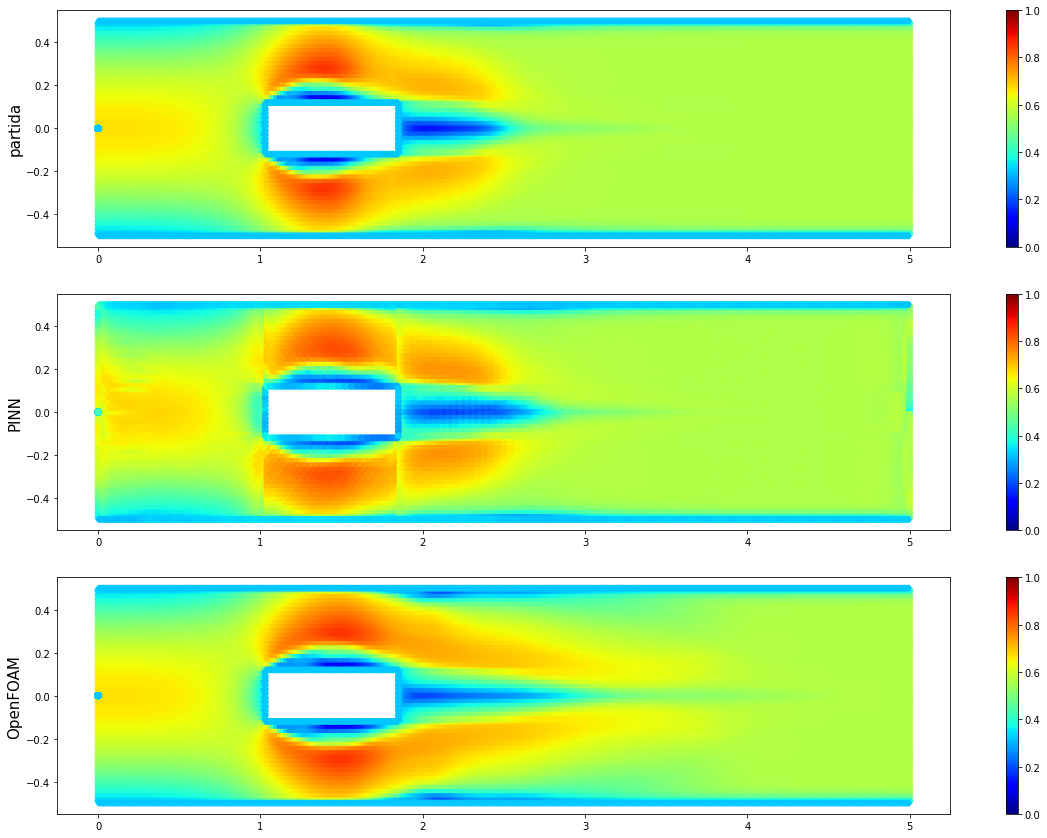

In [ ]:
i=1
sim= 0
variable = 0
x = x_test[sim,i,:,3]
y = x_test[sim,i,:,4]
z_partida = x_test[sim,i,:,variable]
z = y_test[sim,i,:,variable]
z_model = model(x_test[sim,:,:,0:3].reshape((1,) + (49,13104,3)))[0,i,:,variable]

print(np.max( y_train[sim,:,variable]) )
print(z.shape)


fig = plt.figure(figsize=(20,20))

plt.subplot(412)
plt.ylabel('PINN', fontsize=15)
plt.scatter(x, y, c=z_model, cmap='jet', vmax = 1, vmin=0)
plt.colorbar()


plt.subplot(413)
plt.ylabel('OpenFOAM', fontsize=15)
plt.scatter(x, y, c=z, cmap='jet', vmax = 1, vmin=0)
plt.colorbar()

plt.subplot(411)
plt.ylabel('partida', fontsize=15)
plt.scatter(x, y, c=z_partida, cmap='jet', vmax = 1, vmin=0)
plt.colorbar()

plt.show()

In [ ]:
z_model.shape
print(z_model[5])
print(z[5])

tf.Tensor(0.92715997, shape=(), dtype=float32)
1.49801


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from scipy.interpolate import griddata
import numpy as np

i=29
x = x_test[i,:,3]
y = x_test[i,:,4]
z = y_test[i,:,0]

idx = np.lexsort((y, x)).reshape(50, 250)

#plt.imshow(x[idx], y[idx], z[idx], cmap = 'jet',extent=[x.min(), x.max(), -3, 3] )

plt.imshow( z[idx], interpolation='bilinear', cmap='jet',
               origin='lower', extent=[-3, 3, -3, 3],
               vmax=1, vmin=0)


ValueError: ignored

In [ ]:
fd

# RUN ALL

In [ ]:
from keras.callbacks import EarlyStopping, TensorBoard
import tensorflow as tf
import os
import shutil
import time
import h5py
import keras
import numpy as np
import math
from numba import njit


def read_dataset(path=None, split=0.9, print_shape=False):

    x = []
    y = []
    hdf5_file = h5py.File(path, "r")
    x = hdf5_file["sim_data"][:117, 1:50, ...]
    y = hdf5_file["sim_data"][:117, 2:51, ...]
    sim_no = hdf5_file["sim_no"][:117, 0]
    hdf5_file.close()

    times = 49

    @njit
    def index(array, item):
      for idx, val in np.ndenumerate(array):
        if val == item:
            return idx
    # If no item was found return None, other return types might be a problem due to
    # numbas type inference.


    for i in range(y.shape[0]):
      indice = index(y[i,0,:,0] , -100.0 )[0]
      if np.max(y[i,:,:indice,0])-np.min(y[i,:,:indice,0]) != 0:
        y[i,:,:indice,0] = (y[i,:,:indice,0] - np.ones((y[i,:,:indice,0].shape))*np.min(y[i,:,:indice,0]))/(np.max(y[i,:,:indice,0])-np.min(y[i,:,:indice,0]))
        y[i,:,:indice,1] = (y[i,:,:indice,1] - np.ones((y[i,:,:indice,1].shape))*np.min(y[i,:,:indice,1]))/(np.max(y[i,:,:indice,1])-np.min(y[i,:,:indice,1]))
        y[i,:,:indice,2] = (y[i,:,:indice,2] - np.ones((y[i,:,:indice,2].shape))*np.min(y[i,:,:indice,2]))/(np.max(y[i,:,:indice,2])-np.min(y[i,:,:indice,2]))

    for i in range(x.shape[0]):
      indice = index(x[i,0,:,0] , -100.0 )[0]
      if np.max(x[i,:,:indice,0])-np.min(x[i,:,:indice,0]) != 0:
        x[i,:,:indice,0] = (x[i,:,:indice,0] - np.ones((x[i,:,:indice,0].shape))*np.min(x[i,:,:indice,0]))/(np.max(x[i,:,:indice,0])-np.min(x[i,:,:indice,0]))
        x[i,:,:indice,1] = (x[i,:,:indice,1] - np.ones((x[i,:,:indice,1].shape))*np.min(x[i,:,:indice,1]))/(np.max(x[i,:,:indice,1])-np.min(x[i,:,:indice,1]))
        x[i,:,:indice,2] = (x[i,:,:indice,2] - np.ones((x[i,:,:indice,2].shape))*np.min(x[i,:,:indice,2]))/(np.max(x[i,:,:indice,2])-np.min(x[i,:,:indice,2]))



    total_sim = x.shape[0]

    x_train = x[:int(total_sim * split), ...]
    y_train = y[:int(total_sim * split), ...]
    x_test = x[int(total_sim * split):total_sim, ...]
    y_test = y[int(total_sim * split):total_sim, ...]
    sim_no_train = sim_no[:int(total_sim * split), ...]
    sim_no_test = sim_no[int(total_sim * split):total_sim, ...]


    if print_shape:
        print("total_sim: {}\nx_train.shape: {}\ny_train.shape: {}\nx_test.shape: {}\ny_test.shape: {}\n".format(
            total_sim,
            x_train.shape,
            y_train.shape,
            x_test.shape,
            y_test.shape))

    return x_train, y_train, x_test, y_test

hdf5_path = '/content/all_data.hdf5'
x_train, y_train, x_test, y_test = read_dataset(hdf5_path, split=0.9, print_shape=True)


assert not np.any(np.isnan(x_train))
assert not np.any(np.isnan(y_train))

assert not np.any(np.isnan(x_test))
assert not np.any(np.isnan(y_test))


#tf records

# Convert values to compatible tf.Example types.
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy()  # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))
def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))
def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def parse_single_image(image, label):

  #define the dictionary -- the structure -- of our single example
  data = {
        'height' : _int64_feature(image.shape[0]),
        'depth_x' : _int64_feature(image.shape[1]),
        'depth_y' : _int64_feature(label.shape[1]),
        'raw_image' : _bytes_feature(tf.io.serialize_tensor(image)),
        'label' : _bytes_feature(tf.io.serialize_tensor(label)),
    }
  #create an Example, wrapping the single features
  out = tf.train.Example(features=tf.train.Features(feature=data))

  return out

def write_images_to_tfr_short(images, labels, filename:str="images"):
  filename= filename+".tfrecords"
  writer = tf.io.TFRecordWriter(filename) #create a writer that'll store our data to disk
  count = 0

  for index in range(len(images)):

    #get the data we want to write
    current_image = images[index].astype('float64')
    current_label = labels[index].astype('float64')

    out = parse_single_image(image=current_image, label=current_label)
    writer.write(out.SerializeToString())
    count += 1

  writer.close()
  print(f"Wrote {count} elements to TFRecord")
  return count

count = write_images_to_tfr_short(x_train[:,:,:,0:3], y_train[:,:,:,0:3], filename="small_images_train_50")
count = write_images_to_tfr_short(x_test[:,:,:,0:3], y_test[:,:,:,0:3], filename="small_images_test_50")

total_sim: 117
x_train.shape: (105, 49, 13104, 5)
y_train.shape: (105, 49, 13104, 5)
x_test.shape: (12, 49, 13104, 5)
y_test.shape: (12, 49, 13104, 5)

Wrote 105 elements to TFRecord
Wrote 12 elements to TFRecord


In [ ]:
import tensorflow as tf
import os
import shutil
import time
import h5py
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras import Model
from tensorflow.keras import Input
from tensorflow.keras.layers import ZeroPadding2D, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

def parse_tfr_element(element):
  #use the same structure as above; it's kinda an outline of the structure we now want to create
  data = {
      'height': tf.io.FixedLenFeature([], tf.int64),
      'label' : tf.io.FixedLenFeature([], tf.string),
      'raw_image' : tf.io.FixedLenFeature([], tf.string),
      'depth_x':tf.io.FixedLenFeature([], tf.int64),
      'depth_y':tf.io.FixedLenFeature([], tf.int64)
    }

  content = tf.io.parse_single_example(element, data)
  
  height = content['height']
  depth_x = content['depth_x']
  depth_y = content['depth_y']
  label = content['label']
  raw_image = content['raw_image']
  
  
  #get our 'feature'-- our image -- and reshape it appropriately
  
  feature = tf.io.parse_tensor(raw_image, out_type=tf.float64)
  label = tf.io.parse_tensor(label, out_type=tf.float64)


  return (feature, label)

def load_dataset(filename, batch_size, buffer_size):
  #create the dataset
  dataset = tf.data.TFRecordDataset(filename)

    #pass every single feature through our mapping function
  dataset = dataset.map(
      parse_tfr_element
  )

  #dataset = dataset.shuffle(buffer_size=buffer_size )
  #epoch = tf.data.Dataset.range(epoch_num)
  dataset = dataset.batch(batch_size)

  return dataset  
  #return tf.compat.v1.data.make_one_shot_iterator(dataset)

train_path = "/content/small_images_train_50.tfrecords"
test_path = "/content/small_images_test_50.tfrecords"

batch_size = 1

train_dataset = load_dataset(filename = train_path, batch_size= batch_size, buffer_size=1024)
test_dataset = load_dataset(filename = test_path, batch_size= batch_size, buffer_size=1024)

#train_len = x_train.shape[0]
x_train, x_test, y_train,  y_test = None, None, None, None


#model

#@tf.function
def conv_model():

  inputs = tf.keras.Input(shape=(None, 52 * 252, 3))

  layer = tf.keras.layers.Conv1D(32, 2, activation='relu', padding='same')(inputs)

  c1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(32, 2, activation='relu', padding='same'))(layer)  # (None, 50, 150, 32)
  x = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling1D(2, padding='same'))(c1)  # (None, 25, 75, 32)

  c2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(64, 2, activation='relu', padding='same'))(x)  # (None, 25, 75, 64)
  x = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling1D(2, padding='same'))(c2)  # (None, 13, 38, 64)

  c3 = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(128, 2, activation='relu', padding='same'))(x)  # (None, 13, 38, 128)
  x = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling1D(2, padding='same'))(c3)  # (None, 7, 19, 128)

  x = tf.keras.layers.ConvLSTM1D(filters=256, kernel_size=3, activation='relu',
                  recurrent_activation='sigmoid', padding='same', return_sequences=True)(x)

  x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1DTranspose(128, 2, strides=2, padding='same'))(x)
  #x = tf.keras.layers.TimeDistributed(tf.keras.layers.Cropping1D(cropping=(1, 0))(x)
  x = tf.keras.layers.Add()([x, c3])

  x = tf.keras.layers.ConvLSTM1D(filters=128, kernel_size=3, activation='relu',
                  recurrent_activation='sigmoid', padding='same', return_sequences=True)(x)

  x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1DTranspose(64, 2, strides=2, padding='same'))(x)
  #x = tf.keras.layers.TimeDistributed(tf.keras.layers.Cropping1D(cropping=((1, 0)))(x)
  x = tf.keras.layers.Add()([x, c2])



  x = tf.keras.layers.ConvLSTM1D(filters=64, kernel_size=3, activation='relu',
                  recurrent_activation='sigmoid', padding='same', return_sequences=True)(x)

  x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1DTranspose(32, 3 , strides=2 , padding='same'))(x)
  x = tf.keras.layers.Add()([x, c1])

  x = tf.keras.layers.Conv1D(filters=3, kernel_size= 3 , activation='sigmoid', padding='same', data_format='channels_last')(x)



  output_layer =  tf.keras.layers.Dense(3, activation='sigmoid')(x)
  
  model = tf.keras.Model(inputs=[inputs], outputs = [output_layer])

  print(model.summary())
  return model

#training 


from numba import njit

@njit
def index(array, item):
    for idx, val in np.ndenumerate(array):
        if val == item:
            return idx
    # If no item was found return None, other return types might be a problem due to
    # numbas type inference.



def my_mse_loss():
  def equation_loss(y_true, y_pred):

    loss = 0

    for i in range(y_true.shape[0]):
      y = np.array(y_true[i,0,:,0])
      indice = index(y , -100.0 )[0]

      ux = y_true[i,:,:indice,0]
      uy = y_true[i,:,:indice,1]
      p = y_true[i,:,:indice,2]

      
      ux_pred = y_pred[i,:,:indice,0]
      uy_pred = y_pred[i,:,:indice,1]
      p_pred = y_pred[i,:,:indice,2]
      print(tf.square(ux - ux_pred) + \
                  tf.square(uy - uy_pred) + \
                  tf.square(p - p_pred))

      loss += tf.reduce_mean(tf.square(ux - ux_pred) + \
                  tf.square(uy - uy_pred) + \
                  tf.square(p - p_pred))
      
    loss /= y_true.shape[0]
    print(loss)
    return loss

  return equation_loss

lr = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.45*lr, amsgrad=True)
#loss_object = tf.keras.losses.MeanSquaredError()
#loss_object = eq_loss()

loss_object = my_mse_loss()
#train_acc_metric = tf.keras.metrics.MeanSquaredError()
#val_acc_metric = tf.keras.metrics.MeanSquaredError()


#coding the training
#@tf.function
def apply_gradient(optimizer, model , x, y):
  with tf.GradientTape() as tape:
    logits = model(x)  #predictions from the model at this moment
    #loss_value = loss_object(y_true = y , y_pred = logits, x=x) #calculate loss given the predictions - logits
    loss_value = loss_object(y_true = y , y_pred = logits)
  gradients = tape.gradient(loss_value, model.trainable_weights)
  optimizer.apply_gradients(zip(gradients,model.trainable_weights)) #zip to build tuple

  return logits, loss_value

#@tf.function
def train_data_for_one_epoch():
  losses = []  #loss per batch
  
  #pbar=tqdm(total=len(list(enumerate(train))), position=0, leave = True, bar_format = '{1_bar}{bar}| {n_fms}/{total_fms} ')

  for step, (x_batch_train, y_batch_train) in enumerate (train_dataset):

    x_batch_train = tf.cast(x_batch_train, dtype='float32')
    y_batch_train = tf.cast(y_batch_train, dtype='float32')
    
    logits , loss_value = apply_gradient(optimizer , model , x_batch_train , y_batch_train)

    losses.append(loss_value)

    #train_acc_metric(y_batch_train, logits)
    #pbar.set_description("Training los for step %.4f" % (int(step),float(loss_value)))
    #pbar.update()
    progbar.update(step+1)

  return losses

#@tf.function
def perform_validation():
  losses = []

  for x_val, y_val in test_dataset:
    x_val = tf.cast(x_val, dtype='float32')
    y_val = tf.cast(y_val, dtype='float32')

    val_logits = model(x_val)
    #val_loss = loss_object(y_true= y_val , y_pred = val_logits, x=x_val)
    val_loss = loss_object(y_true= y_val , y_pred = val_logits)
    losses.append(val_loss)
    #val_acc_metric(y_val,val_logits)
  return losses


import math

model = conv_model()
epochs = 50
epochs_val_losses, epochs_train_losses = [], []
train_len = 105

for epoch in range(epochs):
  
  progbar = tf.keras.utils.Progbar(math.ceil(train_len/batch_size))

  print('Start of epoch %d' %(epoch,))

  losses_train = train_data_for_one_epoch()
  #train_acc = train_acc_metric.result()

  losses_val  = perform_validation()
  #val_acc = val_acc_metric.result()

  losses_train_mean = np.mean(losses_train)
  losses_val_mean = np.mean(losses_val)
  epochs_val_losses.append(losses_val_mean)
  epochs_train_losses .append(losses_train_mean)

  print('Epoch %s: Train loss: %.4f , Validation Loss: %.4f , Train Accuracy: %.4f , Validation Accuracy: %.4f \n' % (epoch,float(losses_train_mean), float(losses_val_mean), float(losses_train_mean), float(losses_val_mean)))
  #train_acc_metric.reset_states()
  #val_acc_metric.reset_states()

from keras.callbacks import EarlyStopping, TensorBoard
import tensorflow as tf
import os
import shutil
import time
import h5py
import keras
import numpy as np
import math
from numba import njit


def read_dataset(path=None, split=0.9, print_shape=False):

    x = []
    y = []
    hdf5_file = h5py.File(path, "r")
    x = hdf5_file["sim_data"][:117, 1:50, ...]
    y = hdf5_file["sim_data"][:117, 2:51, ...]
    sim_no = hdf5_file["sim_no"][:117, 0]
    hdf5_file.close()

    times = 49

    @njit
    def index(array, item):
      for idx, val in np.ndenumerate(array):
        if val == item:
            return idx
    # If no item was found return None, other return types might be a problem due to
    # numbas type inference.


    for i in range(y.shape[0]):
      indice = index(y[i,0,:,0] , -100.0 )[0]
      if np.max(y[i,:,:indice,0])-np.min(y[i,:,:indice,0]) != 0:
        y[i,:,:indice,0] = (y[i,:,:indice,0] - np.ones((y[i,:,:indice,0].shape))*np.min(y[i,:,:indice,0]))/(np.max(y[i,:,:indice,0])-np.min(y[i,:,:indice,0]))
        y[i,:,:indice,1] = (y[i,:,:indice,1] - np.ones((y[i,:,:indice,1].shape))*np.min(y[i,:,:indice,1]))/(np.max(y[i,:,:indice,1])-np.min(y[i,:,:indice,1]))
        y[i,:,:indice,2] = (y[i,:,:indice,2] - np.ones((y[i,:,:indice,2].shape))*np.min(y[i,:,:indice,2]))/(np.max(y[i,:,:indice,2])-np.min(y[i,:,:indice,2]))

    for i in range(x.shape[0]):
      indice = index(x[i,0,:,0] , -100.0 )[0]
      if np.max(x[i,:,:indice,0])-np.min(x[i,:,:indice,0]) != 0:
        x[i,:,:indice,0] = (x[i,:,:indice,0] - np.ones((x[i,:,:indice,0].shape))*np.min(x[i,:,:indice,0]))/(np.max(x[i,:,:indice,0])-np.min(x[i,:,:indice,0]))
        x[i,:,:indice,1] = (x[i,:,:indice,1] - np.ones((x[i,:,:indice,1].shape))*np.min(x[i,:,:indice,1]))/(np.max(x[i,:,:indice,1])-np.min(x[i,:,:indice,1]))
        x[i,:,:indice,2] = (x[i,:,:indice,2] - np.ones((x[i,:,:indice,2].shape))*np.min(x[i,:,:indice,2]))/(np.max(x[i,:,:indice,2])-np.min(x[i,:,:indice,2]))



    total_sim = x.shape[0]

    x_train = x[:int(total_sim * split), ...]
    y_train = y[:int(total_sim * split), ...]
    x_test = x[int(total_sim * split):total_sim, ...]
    y_test = y[int(total_sim * split):total_sim, ...]
    sim_no_train = sim_no[:int(total_sim * split), ...]
    sim_no_test = sim_no[int(total_sim * split):total_sim, ...]


    if print_shape:
        print("total_sim: {}\nx_train.shape: {}\ny_train.shape: {}\nx_test.shape: {}\ny_test.shape: {}\n".format(
            total_sim,
            x_train.shape,
            y_train.shape,
            x_test.shape,
            y_test.shape))

    return x_train, y_train, x_test, y_test


hdf5_path = '/homes/up201605045/codes_upload/dl_data/all_data_vanKarman.hdf5'
x_train, y_train, x_test, y_test = read_dataset(hdf5_path, split=0.9, print_shape=True)

#save the model

loss_object = tf.keras.losses.MeanSquaredError()

model.compile(optimizer,loss_object)
score = model.evaluate(x=x_test[:10,:,0:3], y=y_test[:10,:,0:3], verbose=0)

print('Average Mean Squared Error:', score)
model.save('my_model_100epoch.h5')





Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7f5b179cec20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/iterator_ops.py", line 546, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1264, in delete_iterator
    _ctx, "DeleteIterator", name, handle, deleter)
KeyboardInterrupt: 


KeyboardInterrupt: ignored